# Техническое задание Маркетинг

## Описание проекта и данных

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

**Цель:**

Предсказать вероятность покупки в течение 90 дней


**Задачи:**

- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику roc_auc
- Выполнить тестирование




**Описание данных:**

1) Таблица `apparel-purchases` - данные о покупках клиентов по дням и по товарам. 
   - `client_id` - идентификатор клиента
   - `quantity` - количество единиц товара
   - `price` - цена товара
   - `category_ids` - идентификаторы категорий
   - `date` - дата покупки
   - `message_id` - идентификатор сообщения из рассылки
    
    
2) Таблица `apparel-messages` - рассылки, которые были отправлены клиентам из таблицы покупок.
   - `bulk_campaign_id` - идентификатор рассылки
   - `client_id` - идентификатор клиента 
   - `message_id` - идентификатор сообщения
   - `event` - действие с сообщением (отправлено, открыто, покупка…)
   - `channel` - канал рассылки
   - `date` - дата действия
   - `created_at` - дата-время полностью
     
     
3) Таблица `target` - целевой признак:
  - `client_id` - идентификатор клиента
  - `target` - клиент совершил покупку в целевом периоде



4) `full_campaign_daily_event` - агрегация общей базы рассылок по дням и типам событий
  - `date` - дата
  - `bulk_campaign_id` - идентификатор рассылки
  - `count_event*` - общее количество каждого события event
  - `nunique_event*` - количество уникальных client_id в каждом событии
    
 
 5) `full_campaign_daily_event_channel` - агрегация по дням с учетом событий и каналов рассылки
  - `date` - дата
  - `bulk_campaign_id` - идентификатор рассылки
  - `count_event*_channel*` - общее количество каждого события по каналам
  - `nunique_event*_channel*` - количество уникальных client_id по событиям и каналам

Шаги проекта по задаче 1:

[1 Загрузка и подготовка данных](#Шаг_1)

[2 Обучение моделей](#Шаг_2)

[3 Анализ моделей](#Шаг_3)

[4 Вывод](#Шаг_4)


## Импорт и настройки библиотек 

In [53]:
#Установка библиотек
!pip install scikit-learn==1.1.3
!pip install shap -q
!pip -q install phik
!pip install lightgbm
!pip install catboost

In [54]:
#Импорт библиотек
import shap
import pandas as pd
import seaborn as sns
import numpy as np
import math
import phik #phik_matrix
import time # время time.time()
import lightgbm
import scipy.stats as st
#import missingno as msno #Визуализация пропусков
import warnings # Работа с предупреждениями.
warnings.filterwarnings("ignore")
#Настройка исрументов
from matplotlib import pyplot as plt #Диаграмы
from sklearn.linear_model import LinearRegression,LogisticRegression # регрессии
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor #деревянные модели
#from catboost import CatBoostClassifier,CatBoostRegressor #
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.metrics import mean_squared_error #Метрика MSE 
from sklearn.metrics import mean_absolute_error #Метрика MAE
from sklearn.metrics import r2_score #Метрика детерминации R2
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score,f1_score # загружаем функцию для работы с метриками
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline # загружаем класс pipeline
from sklearn.impute import SimpleImputer # загружаем класс для работы с пропусками
from sklearn.metrics import make_scorer
from numpy.random import RandomState
from ast import literal_eval
import ast


state = RandomState(12345) 
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [55]:
#Настройки пандас
pd.set_option('display.max_columns', None)# Отображение всех столбцов в таблице;
pd.set_option('display.max_rows', None) # Отображение всех строк в таблице;
pd.set_option('display.max_colwidth', None) # текст в ячейке отражался полностью вне зависимости от длины;
pd.set_option('display.float_format', '{:.2f}'.format) #-все числа отражались с двумя знаками после запятой;

## Загрузка данных и предобработка данных

In [56]:
apparel_messages = pd.read_csv(r'C:\Users\ВТБ\Desktop\practicum\Workshop Ds2\STD_M2_purchase_in_90_days\filtered_data\apparel-messages.csv',parse_dates=['date','created_at'], dayfirst=True) #created_at
apparel_purchases = pd.read_csv(r'C:\Users\ВТБ\Desktop\practicum\Workshop Ds2\STD_M2_purchase_in_90_days\filtered_data\apparel-purchases.csv',parse_dates=['date'], dayfirst=True)
apparel_target_binary = pd.read_csv(r'C:\Users\ВТБ\Desktop\practicum\Workshop Ds2\STD_M2_purchase_in_90_days\filtered_data\apparel-target_binary.csv')
full_campaign_daily_event = pd.read_csv(r'C:\Users\ВТБ\Desktop\practicum\Workshop Ds2\STD_M2_purchase_in_90_days\filtered_data\full_campaign_daily_event.csv', parse_dates=['date'], dayfirst=True)
full_campaign_daily_event_channel = pd.read_csv(r'C:\Users\ВТБ\Desktop\practicum\Workshop Ds2\STD_M2_purchase_in_90_days\filtered_data\full_campaign_daily_event_channel.csv', parse_dates=['date'], dayfirst=True)

In [57]:
def data_info(df):
#Общая инвормация
#    print('Информация по',return(df))
    print('Количество строк - ', df.shape[0])
    print('Количество столбцов -', df.shape[1],end='\n\n')
    df.info()
    print()
    display(df.head(3))
#поиск пропусков    
    isnaPD = pd.concat([(df.isna().sum()),((df.isna().sum()/df.isna().count()*100).round(2))], axis =1)
    isnaPD.columns= ['Количество пропусков','% пропусков']
    display(isnaPD)
#Поиск явных дубликатов
    print()
    print('Количество явных дубликатов в данных:',df.duplicated().sum(),end='\n')
    print('Доля явных дубликатов:', round(df.duplicated().sum()/df.shape[0]*100, 2),'%',end='\n\n')
#Проверка на неявные дубликаты
    cat_col_names = df.select_dtypes(exclude='number').columns.tolist()
    for i in cat_col_names:
        print (df[i].unique())
        print()

In [58]:
data_info(apparel_target_binary)

Количество строк -  49849
Количество столбцов - 2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB



,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0


,Количество пропусков,% пропусков
client_id,0,0.00
target,0,0.00



Количество явных дубликатов в данных: 0
Доля явных дубликатов: 0.0 %



In [59]:
apparel_target_binary['target'].value_counts()

0    48888
1      961
Name: target, dtype: int64

В целевом признаке:
- Количество строк -  49849 строк(48888 с признаком 0 и 961 с признаком 1)  и 2 столбца.
- Целевой признак не сбалансированный.
- Наименования столбцов соответствуют змеиному регистру.
- Типы данных соответствуют.
- Пропуски отсутствуют.
- Явные и не явные дубликаты отсутствуют.

In [60]:
data_info(apparel_purchases)

Количество строк -  202208
Количество столбцов - 6

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB



,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.00,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843


,Количество пропусков,% пропусков
client_id,0,0.00
quantity,0,0.00
price,0,0.00
category_ids,0,0.00
date,0,0.00
message_id,0,0.00



Количество явных дубликатов в данных: 73020
Доля явных дубликатов: 36.11 %

["['4', '28', '57', '431']" "['4', '28', '244', '432']"
 "['4', '28', '49', '413']" "['2', '18', '258', '441']"
 "['2', '18', '341', '1311']" "['2', '18', '123', '451']"
 "['5562', '5631', '5549', '667']" "['5562', '5630', '5649', '678']"
 "['4', '27', '350', '1392']" "['4', '28', '44', '490']"
 "['2', '18', '267', '443']" "['4', '28', '213', '417']"
 "['5562', '5589', '5584', '1786']" "['5562', '5589', '5584', '1795']"
 "['5562', '5630', '5699', '550']" "['5562', '5634', '5579', '710']"
 "['5562', '5634', '5568', '957']" "['5562', '5634', '5693', '636']"
 "['2', '18', '344', '445']" "['4', '27', '353', '840']"
 "['4', '28', '343', '425']" "['4', '31', '326', '505']"
 "['4', '28', '260', '420']" "['5562', '5631', '5622', '560']"
 "['5562', '5631', '5549', '608']" "['4', '28', '290', '424']"
 "['2', '18', '212', '658']" "['4', '27', '142', '496']"
 "['4', '28', '213', '436']" "['4', '28', '275', '421']"
 "['4',

Признаки apparel_purchase:

- Количество строк -  202208 и 6 столбцов.
- Наименования столбцов соответствуют змеиному регистру.
- Типы данных соответствуют.
- Пропуски отсутствуют.
- Количество явных дубликатов в данных: 73020- 
Доля явныхддубликатов: 36.1 процентов -треть выборки.

In [61]:
data_info(apparel_messages)

Количество строк -  12739798
Количество столбцов - 7

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB



,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49


,Количество пропусков,% пропусков
bulk_campaign_id,0,0.00
client_id,0,0.00
message_id,0,0.00
event,0,0.00
channel,0,0.00
date,0,0.00
created_at,0,0.00



Количество явных дубликатов в данных: 48610
Доля явных дубликатов: 0.38 %

['1515915625626736623-4439-6283415ac07ea'
 '1515915625490086521-4439-62834150016dd'
 '1515915625553578558-4439-6283415b36b4f' ...
 '1515915625490988866-14656-65ce97f929ca4'
 '1515915625617022616-14656-65ce97f9299fe'
 '1515915625491736359-14656-65ce97f92a3fd']

['open' 'click' 'purchase' 'send' 'unsubscribe' 'hbq_spam' 'hard_bounce'
 'subscribe' 'soft_bounce' 'complain' 'close']

['email' 'mobile_push']

['2022-05-19T00:00:00.000000000' '2022-05-20T00:00:00.000000000'
 '2022-05-21T00:00:00.000000000' '2022-05-22T00:00:00.000000000'
 '2022-05-23T00:00:00.000000000' '2022-05-24T00:00:00.000000000'
 '2022-05-25T00:00:00.000000000' '2022-05-26T00:00:00.000000000'
 '2022-05-27T00:00:00.000000000' '2022-05-28T00:00:00.000000000'
 '2022-05-29T00:00:00.000000000' '2022-05-30T00:00:00.000000000'
 '2022-05-31T00:00:00.000000000' '2022-06-01T00:00:00.000000000'
 '2022-06-02T00:00:00.000000000' '2022-06-03T00:00:00.00000000

Признаки apparel_messages:

- Количество строк -  12739798 и 7 столбцов.
- Наименования столбцов соответствуют змеиному регистру.
- Типы данных соответствуют.
- Пропуски отсутствуют.
- Количество явных дубликатов в данных: 48610
- Доля явных дубликатов: 0.38 % дубликаты можно удалить.

In [62]:
data_info(full_campaign_daily_event)

Количество строк -  131072
Количество столбцов - 24

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 131072 non-null  datetime64[ns]
 1   bulk_campaign_id     131072 non-null  int64         
 2   count_click          131072 non-null  int64         
 3   count_complain       131072 non-null  int64         
 4   count_hard_bounce    131072 non-null  int64         
 5   count_open           131072 non-null  int64         
 6   count_purchase       131072 non-null  int64         
 7   count_send           131072 non-null  int64         
 8   count_soft_bounce    131072 non-null  int64         
 9   count_subscribe      131072 non-null  int64         
 10  count_unsubscribe    131072 non-null  int64         
 11  nunique_click        131072 non-null  int64         
 12  nunique_complain   

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0


,Количество пропусков,% пропусков
date,0,0.00
bulk_campaign_id,0,0.00
count_click,0,0.00
count_complain,0,0.00
count_hard_bounce,0,0.00
count_open,0,0.00
count_purchase,0,0.00
count_send,0,0.00
count_soft_bounce,0,0.00
count_subscribe,0,0.00



Количество явных дубликатов в данных: 0
Доля явных дубликатов: 0.0 %

['2022-05-19T00:00:00.000000000' '2022-05-20T00:00:00.000000000'
 '2022-05-21T00:00:00.000000000' '2022-05-22T00:00:00.000000000'
 '2022-05-23T00:00:00.000000000' '2022-05-24T00:00:00.000000000'
 '2022-05-25T00:00:00.000000000' '2022-05-26T00:00:00.000000000'
 '2022-05-27T00:00:00.000000000' '2022-05-28T00:00:00.000000000'
 '2022-05-29T00:00:00.000000000' '2022-05-30T00:00:00.000000000'
 '2022-05-31T00:00:00.000000000' '2022-06-01T00:00:00.000000000'
 '2022-06-02T00:00:00.000000000' '2022-06-03T00:00:00.000000000'
 '2022-06-04T00:00:00.000000000' '2022-06-05T00:00:00.000000000'
 '2022-06-06T00:00:00.000000000' '2022-06-07T00:00:00.000000000'
 '2022-06-08T00:00:00.000000000' '2022-06-09T00:00:00.000000000'
 '2022-06-10T00:00:00.000000000' '2022-06-11T00:00:00.000000000'
 '2022-06-12T00:00:00.000000000' '2022-06-13T00:00:00.000000000'
 '2022-06-14T00:00:00.000000000' '2022-06-15T00:00:00.000000000'
 '2022-06-16T00:00:

Признаки full_campaign_daily_event:

- Количество строк -  131072 и 24 столбца.
- Наименования столбцов соответствуют змеиному регистру.
- Типы данных соответствуют.
- Пропуски отсутствуют.
- Дубликаты отсутствуют.

In [63]:
data_info(full_campaign_daily_event_channel)

Количество строк -  131072
Количество столбцов - 36

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   date                             131072 non-null  datetime64[ns]
 1   bulk_campaign_id                 131072 non-null  int64         
 2   count_click_email                131072 non-null  int64         
 3   count_click_mobile_push          131072 non-null  int64         
 4   count_open_email                 131072 non-null  int64         
 5   count_open_mobile_push           131072 non-null  int64         
 6   count_purchase_email             131072 non-null  int64         
 7   count_purchase_mobile_push       131072 non-null  int64         
 8   count_soft_bounce_email          131072 non-null  int64         
 9   count_subscribe_email            131072 non-null  int64      

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,Количество пропусков,% пропусков
date,0,0.00
bulk_campaign_id,0,0.00
count_click_email,0,0.00
count_click_mobile_push,0,0.00
count_open_email,0,0.00
count_open_mobile_push,0,0.00
count_purchase_email,0,0.00
count_purchase_mobile_push,0,0.00
count_soft_bounce_email,0,0.00
count_subscribe_email,0,0.00



Количество явных дубликатов в данных: 0
Доля явных дубликатов: 0.0 %

['2022-05-19T00:00:00.000000000' '2022-05-20T00:00:00.000000000'
 '2022-05-21T00:00:00.000000000' '2022-05-22T00:00:00.000000000'
 '2022-05-23T00:00:00.000000000' '2022-05-24T00:00:00.000000000'
 '2022-05-25T00:00:00.000000000' '2022-05-26T00:00:00.000000000'
 '2022-05-27T00:00:00.000000000' '2022-05-28T00:00:00.000000000'
 '2022-05-29T00:00:00.000000000' '2022-05-30T00:00:00.000000000'
 '2022-05-31T00:00:00.000000000' '2022-06-01T00:00:00.000000000'
 '2022-06-02T00:00:00.000000000' '2022-06-03T00:00:00.000000000'
 '2022-06-04T00:00:00.000000000' '2022-06-05T00:00:00.000000000'
 '2022-06-06T00:00:00.000000000' '2022-06-07T00:00:00.000000000'
 '2022-06-08T00:00:00.000000000' '2022-06-09T00:00:00.000000000'
 '2022-06-10T00:00:00.000000000' '2022-06-11T00:00:00.000000000'
 '2022-06-12T00:00:00.000000000' '2022-06-13T00:00:00.000000000'
 '2022-06-14T00:00:00.000000000' '2022-06-15T00:00:00.000000000'
 '2022-06-16T00:00:

Признаки full_campaign_daily_event_channel:

- Количество строк -  131072 и 36 столбца.
- Наименования столбцов соответствуют змеиному регистру.
- Типы данных соответствуют.
- Пропуски отсутствуют.
- Дубликаты отсутствуют.

**Данные загружены.**

## Предобработка данных

### Удаление дубликатов

Дубликаты найдены в 2х таблицах apparel_messages, apparel_purchases. Рассмотрим возможность удалени.

In [64]:
#рассмотрим дубликаты в apparel_messages на примере клиента 1515915625554535987
apparel_messages[(apparel_messages['client_id']==1515915625554535987)&(apparel_messages.duplicated(keep=False))]

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
964231,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56
964232,5723,1515915625554535987,1515915625554535987-5723-62e2af08e00da,click,mobile_push,2022-07-28,2022-07-28 15:58:56
2689031,8131,1515915625554535987,1515915625554535987-8131-637f837c11dc8,click,mobile_push,2022-11-24,2022-11-24 14:54:44
2689032,8131,1515915625554535987,1515915625554535987-8131-637f837c11dc8,click,mobile_push,2022-11-24,2022-11-24 14:54:44


Согласно выборочным значениям дубликаты являются полными(события совпадают, идентификаторы совпадают, даже время события совпадает до секнды). Дополнительно учитывая, что их всего 0.38% их можно удалить.

In [65]:
#удвление дубликатов
apparel_messages=apparel_messages.drop_duplicates().reset_index(drop=True)
#Проверим
print('Количество дубликатов в apparel_messages:',apparel_messages.duplicated().sum())

Количество дубликатов в apparel_messages: 0


In [66]:
#Посмотрим на  дубликаты в apparel_purchases
apparel_purchases[apparel_purchases.duplicated()].head(3)

,client_id,quantity,price,category_ids,date,message_id
12,1515915625491869271,2,599.00,"['4', '27', '350', '1392']",2022-05-16,1515915625491869271-2090-61a72488d6a0f
22,1515915625566606509,1,299.00,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
42,1515915625468070175,1,2199.00,"['4', '27', '142', '496']",2022-05-17,1515915625468070175-4439-6283414668daa


In [67]:
apparel_purchases[(apparel_purchases['client_id']==1515915625566606509)&(apparel_purchases.duplicated(keep=False))]

,client_id,quantity,price,category_ids,date,message_id
21,1515915625566606509,1,299.00,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d
22,1515915625566606509,1,299.00,"['5562', '5634', '5579', '710']",2022-05-16,1515915625566606509-4301-627b66245401d


В данном случае все поля совпадают, но нет поля даты с временем. Возможно в интеренет магазине несколько купленных товаров проиваются разово. Посомтрим на признак количество. 

In [68]:
print('Доля значений в общем массиве >1:',round(apparel_purchases[apparel_purchases['quantity']>1]['client_id'].count()/apparel_purchases['client_id'].count()*100,3))

Доля значений в общем массиве >1: 0.438


В 99,5 случаев товар пробивается по штучно. Возможно отсальные шутики это парные товары. В связи с этим не будем удалять явные дубликаты.

Конвертируем 'category_ids'

In [69]:
# Для конвертации списков в корректный формат
def parse_list_column(string):
    # Преобразуем строку в список с помощью ast.literal_eval
    return ast.literal_eval(string)

In [70]:
# Применяем функцию к столбцу
apparel_purchases['category_ids'] = apparel_purchases['category_ids'].apply(parse_list_column)

Типы данных требуемых к замене изменены.

In [71]:
display(apparel_purchases.head(2))


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.00,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.00,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d


### Анаиз Данных

In [72]:
#Посмотрим значение целевого признака в основных таблицах
print('Количество уникальных клиентов:',apparel_target_binary['client_id'].nunique())
print('Совпадение целевого признака с apparel_purchases:',len(set(apparel_purchases['client_id']) & set(apparel_target_binary['client_id'])))
print('Совпадение целевого признака с apparel_message:',len(set(apparel_messages['client_id']) & set(apparel_target_binary['client_id'])))

Количество уникальных клиентов: 49849
Совпадение целевого признака с apparel_purchases: 49849
Совпадение целевого признака с apparel_message: 41982


Количество уникаьльных клиентов в целевом признаке и клиентов в apparel_purchases совпадает.
Количество уникаьльных клиентов в целевом признаке и клиентов в apparel_message разнится на 16%
Придется удалить 16 процентов т.к. по ним не будет признаков в общей таблице

In [73]:
#Подсчет выбросов в количественных значениях
def outliners(df):
    for i in num_col_names:
        outliers = df[i].apply(lambda x: abs(x - df[i].mean()) > 3 * df[i].std())
        print('Процент выбросов в',i,'=',(outliers.sum()/len(df[i])*100).round(2))

In [74]:
num_col_names= ['quantity','price']
#outliners(apparel_purchases)

- Процент выбросов в quantity = 0.44
- Процент выбросов в price = 1.06

In [75]:
##Функция анализа числовых значений
def hist_box(data, column):#, target):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(data[column])#, hue = target)
    plt.xlabel(f'Значения столбца "{column}"')
    plt.ylabel('Частота')
    plt.title(f'Гистограмма для "{column}"')
    plt.axvline(np.median(data[column]), color='red', linestyle='dashed', linewidth=3, label='Медиана')
    plt.axvline(np.mean(data[column]), color='black', linestyle='dashed', linewidth=3, label='Среднее')
    plt.axvline(np.percentile(data[column], 25), color='orange', linestyle='dashed', linewidth=3, label='1-й квартиль')
    plt.axvline(np.percentile(data[column], 75), color='green', linestyle='dashed', linewidth=3, label='3-й квартиль')
    
    plt.subplot(1, 2, 2)
    plt.xlabel(f'Значения столбца {column}')
    plt.title(f'Диаграмма размаха для {column}')
    sns.boxplot(x=data[column])

                   client_id  quantity     price
count              202208.00 202208.00 202208.00
mean  1515915625596210944.00      1.01   1193.30
std             145945755.93      0.18   1342.25
min   1515915625468060928.00      1.00      1.00
25%   1515915625490081280.00      1.00    352.00
50%   1515915625557177088.00      1.00    987.00
75%   1515915625624391936.00      1.00   1699.00
max   1515915626010443520.00     30.00  85499.00


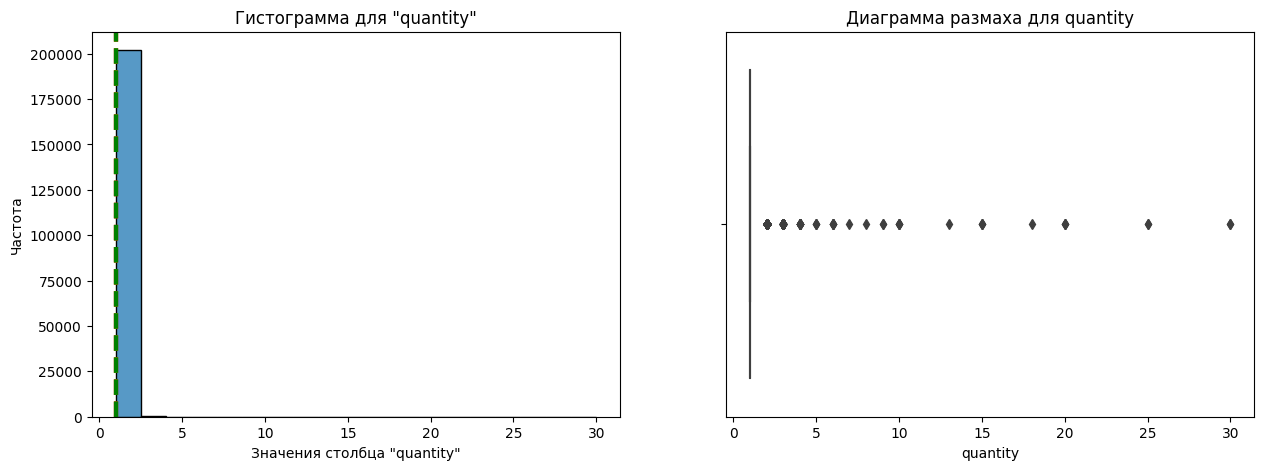

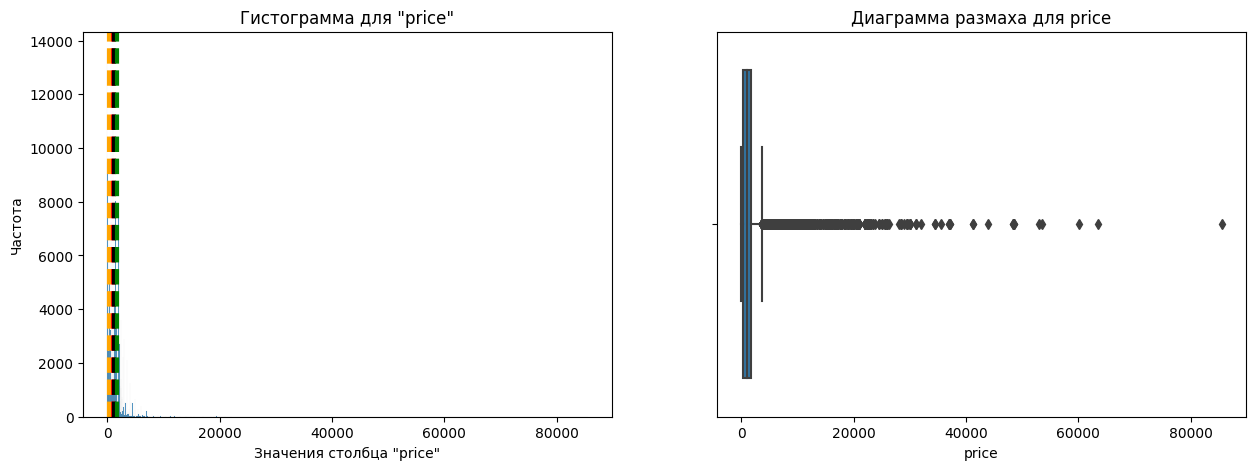

In [76]:
for i in num_col_names:
    hist_box(apparel_purchases, i)
print(apparel_purchases.describe()) 

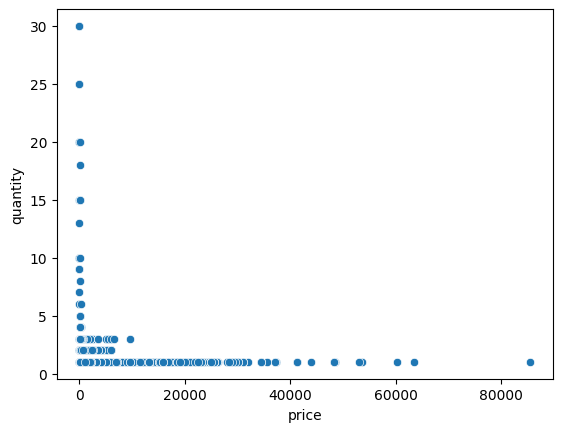

In [77]:
sns.scatterplot(data=apparel_purchases, x='price', y='quantity');
plt.show()

In [78]:
#Аномальные значения находятся после 40 тысяч. исключим значения цены более 40 тысяч.
print('Кол-во строк до удаления',apparel_purchases.shape[0])
apparel_purchases= apparel_purchases[apparel_purchases['price']<=40000]
print('Кол-во строк после удаления',apparel_purchases.shape[0])

Кол-во строк до удаления 202208
Кол-во строк после удаления 202196


## Разработка признаков:

### Разработка прихнаков для 'apparel_purchases'

Согласно заданию "В таблице есть списки идентификаторов, к каким категориям относится товар. Часто
это вложенные категории (например автотовары-аксессуары-освежители), но также может
включать в начале списка маркер распродажи или маркер женщинам/мужчинам.
Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка
или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому
могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594']. Как
обработать такие случаи – можете предлагать свои варианты решения.
Признак category_ids например ['4', '27', '176', '524'] отражает категории и подкатегории продукта.
Подкатегория 44 может быть на любом месте, в связи с чем нет возможности определить категории и что они означают.
Исходя из этого оставим только главную кагегорию.

In [79]:
def category(x):
    if len(x) >= 1:
        return (f'cat_{x[0]}')
    else:
        return 'No_cat'

In [80]:
#сформируем признак категорий
apparel_purchases['category'] = apparel_purchases['category_ids'].apply(category)

Из apparel_purchases можем создать следующие признаки по клинету.
- Общее количество покупок в разрезе клинета.
- Количество покупок по категоряим.
- Общая выручка = количество * доход.


### Разработка прихнаков для 'apparel_messges'

In [81]:
apparel_messages['year'] = apparel_messages['date'].dt.year.astype('str')
apparel_messages['month'] = apparel_messages['date'].dt.month.astype('str')
apparel_messages['event']
apparel_messages.head(2)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,year,month
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20,2022,5
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34,2022,5


In [ ]:
actions_count = apparel_messages.groupby((['client_id', 'action'])['action'].agg('count')

In [ ]:
# Считаем все виды каналов 
channels_count = apparel_messages.groupby(['client_id', 'channel'])['channel'].agg('count')
                               

## Обучение модели

### Разделение на тренировочную и тестовую выборки

In [ ]:
#разделение на тренировочную и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(data.drop(['target'], axis=1),
                                                    data['target'],
                                                    test_size = TEST_SIZE, 
                                                    random_state = RANDOM_STATE)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
#распределим признаки
#ohe_columns = ['gearbox','repaired']
#ord_columns = ['fuel_type','vehicle_type','model','brand']
#ord_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
#num_columns = ['registration_year', 'power', 'kilometer']#, 'registration_month']

# Выбираем количественные и категориальные признаки
num_cols = X_train.select_dtypes(include='number').columns
cat_cols = X_train.select_dtypes(exclude='number').columns

In [ ]:
# создаём пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline([ 
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
    ('ohe', OneHotEncoder(drop = 'first', categories = 'auto',
                          handle_unknown = 'ignore',sparse = False))
    ])

In [ ]:
# создаём пайплайн для подготовки признаков из списка ord_columns
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ]
)

In [ ]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [#('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [ ]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [ ]:
# Функция для расчета основных метрик
def metrics(model, data_X_train, data_y_train, data_X_test, data_y_test, prob=True):
    # Расчитаем основную метрику для кросс-валидации
    roc_auc_crossval = cross_val_score(model, data_X_train, data_y_train, scoring='roc_auc', cv=3).mean()
    
    # Сделаем предсказание
    y_pred = model.predict(data_X_test)
    
    if prob:
        probs = model.predict_proba(data_X_test)[:, 1]
    
    # Расчитаем другие метрики на тесте
    roc_auc_test = roc_auc_score(data_y_test, probs)
    accuracy = accuracy_score(y_pred, data_y_test)
    f1 = f1_score(y_pred, data_y_test)
    precision = precision_score(y_pred, data_y_test)
    recall = recall_score(y_pred, data_y_test)
    
    
    return pd.DataFrame([roc_auc_crossval, roc_auc_test, accuracy, f1, precision, recall],
                 index=['roc_auc_crossval', 'roc_auc_test', 'accuracy', 'f1', 'precision', 'recall'],
                 columns=['metrics']).round(2)

**DecisionTreeClassifier**

In [ ]:
# словарь для модели DecisionTreeRegressor()
param_tree = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }]

In [ ]:
#Поиск параметров модели
random_tree = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_tree, 
     cv=5,
    scoring = 'neg_root_mean_squared_error', 
    n_jobs=-1
)

**LogisticRegression**

In [ ]:
params_lr = [{'model': [LogisticRegression(class_weight='balanced',  random_state=RANDOM_STATE)],
              'model__C': np.arange(0.01, 0.9, 0.05),
              'model__max_iter': [100, 150, 200, 250]
             }]

In [ ]:
random_lr = RandomizedSearchCV(
    final_pipe, 
    param_distributions=params_lg, 
    n_iter=15, 
    scoring='roc_auc', 
    cv=5, 
    random_state=RANDOM_STATE, 
    verbose=3,
    n_jobs=-1)
random_lgbm.fit(X_train, y_train)